In [ ]:
import tdmclient.notebook
await tdmclient.notebook.start()


In [1]:
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import kalman_filter
from test import pathing_bis



In [4]:

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)
    return np.arccos(np.dot(vec1_unit, vec2_unit))


def pathing(position_estimate, theta_estimate, target, min_distance = 50):
    position_history = []
    theta_history = []
    direction = np.array([np.cos(theta_estimate), np.sin(theta_estimate)])
    # outputs, in mm/s
    speed_l = 0
    speed_r = 0
    # in radians
    angle_tolerance = 0.7
    # time step(s)
    dt = 0.01
    # counts nb of steps
    i = 0
    
    distance = math.sqrt((target[0]-position_estimate[0])**2 + (target[1]-position_estimate[1])**2)
    while distance > min_distance:
        depl_left = speed_l * dt 
        depl_right = speed_r * dt 
        depl_center = (depl_right + depl_left)/2
        
        # divided by the wheel distance(in mm) to get the angle(rad), trigonometric sense
        theta = (depl_left - depl_right)/120
        if theta != 0:
            theta_estimate = (theta_estimate + theta) % (2*np.pi)
            
        depl_x = depl_center * np.cos(theta_estimate) 
        depl_y = depl_center * np.sin(theta_estimate)
        position_estimate = position_estimate + np.array([depl_x, depl_y])
        
        # relative target vector with respect to the robot position
        target_direction = target - position_estimate
        direction = np.array([np.cos(theta_estimate), np.sin(theta_estimate)])
        alpha = get_angle_between(target_direction, direction)
        if (alpha <= angle_tolerance and alpha >= 0) or (alpha >= -angle_tolerance and alpha < 0) :
            # move forward, mm/s
            speed_l = 20 - 20 * np.sin(alpha)
            speed_r = 20 + 20 * np.sin(alpha)
        elif alpha > angle_tolerance:            
            speed_l = -20
            speed_r = 20
        elif alpha < - angle_tolerance:
            speed_l = 20
            speed_r = -20
    
        distance = np.sqrt((target[0]-position_estimate[0])**2 + (target[1]-position_estimate[1])**2)

        if i > 1000000 :
            print(i, distance)
            break
        #print(position_estimate, distance) 
        position_history.append(position_estimate)
        theta_history.append(theta_estimate)
        #set_speed(speed_l, speed_r)
        #time.sleep(dt)
        
        i += 1

    return position_history, theta_history



def pathing_bis(position_estimate, theta_estimate,  target, speed_l, speed_r, dt = 0.01):
    angle_tolerance = 0.4

    depl_left = speed_l * dt 
    depl_right = speed_r * dt 
    depl_center = (depl_right + depl_left)/2
    theta = (depl_left - depl_right)
    
    if theta != 0:
        theta_estimate = (theta_estimate + theta) % (2*np.pi)
    
    depl_x = depl_center * np.cos(theta_estimate) 
    depl_y = depl_center * np.sin(theta_estimate)
    position_estimate = position_estimate + np.array([depl_x, depl_y])
    
    target_direction = target - position_estimate
    direction = np.array([np.cos(theta_estimate), np.sin(theta_estimate)])
    alpha = get_angle_between(target_direction, direction)


    if (alpha <= angle_tolerance and alpha >= 0) or (alpha >= -angle_tolerance and alpha < 0) :
        # move forward, mm/s
        speed_l = 50 - 40 * np.sin(alpha)
        speed_r = 50 + 40 * np.sin(alpha)
    elif alpha > angle_tolerance:            
        speed_l = -50
        speed_r = 50 
    elif alpha < - angle_tolerance:
        speed_l = 50
        speed_r = -50
    distance = int(np.sqrt((target[0]-position_estimate[0])**2 + (target[1]-position_estimate[1])**2))
    #set_speed(speed_l, speed_r)
    #time.sleep(dt)

    return distance, position_estimate, theta_estimate, speed_l, speed_r


In [ ]:
# set speed, in mm/s
@tdmclient.notebook.sync_var 
def set_speed(speed_left, speed_right):
    global output_speed_right, output_speed_left
    # max speed is of 500, equivalent to 14cm/s = 140mm/s
    if speed_left > 140:
        speed_left = 140
    if speed_right > 140:
        speed_right = 140
    conversion = 500/140
    output_speed_right = int(speed_right * conversion)
    output_speed_left = int(speed_left * conversion)


# Thymio Code

In [ ]:
%%run_aseba

var output_speed_right = 0
var output_speed_left  = 0
var dt = 10

var shift_left = 0
var shift_right = 0

var internal_pos_est[2] = 0,0

# activates each dt ms
timer.period[0] = dt
# activates each 1000 ms
timer.period[1] = dt 


# on timer0 event, we update the direction of the robot and it's motor speeds
onevent timer0
    # output speed
    motor.left.target = output_speed_left
    motor.right.target = output_speed_right
    

    

# Overseer Code

C:\Users\osour\AppData\Local\Temp\ipykernel_16328\687927355.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


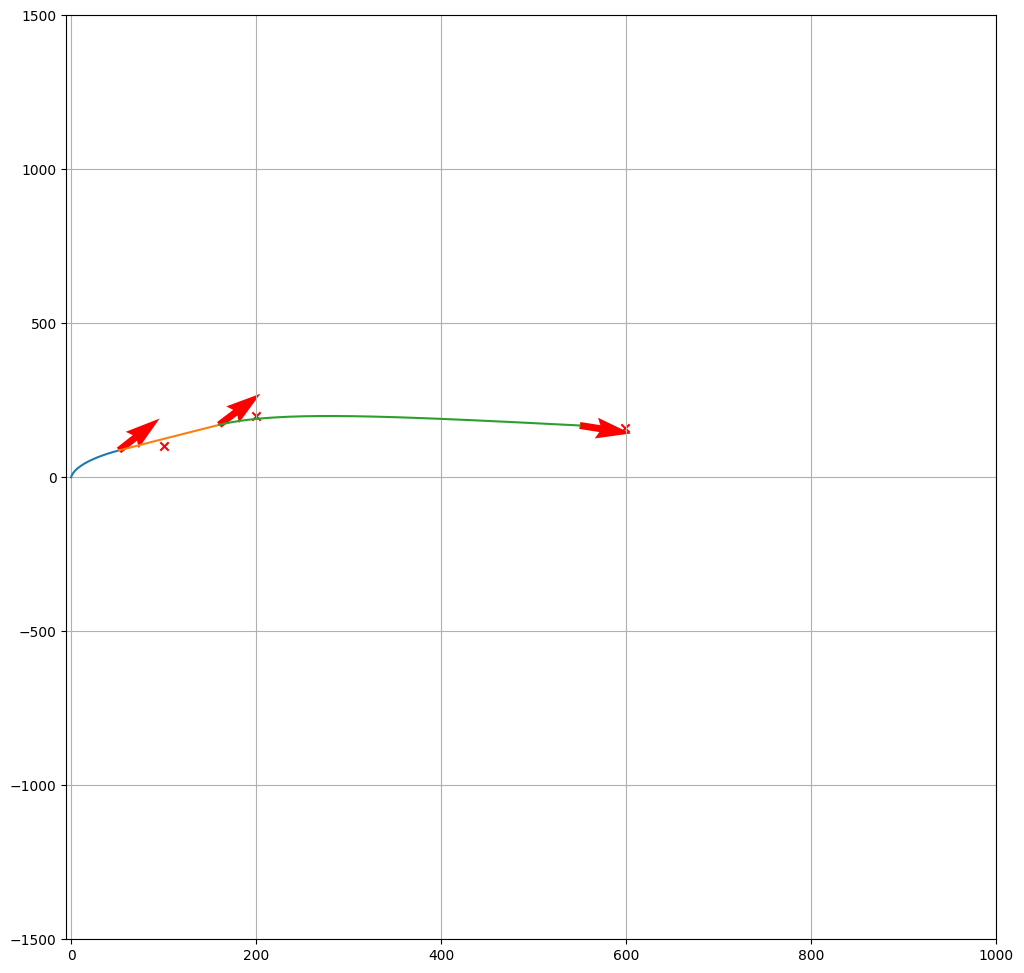

[549.74006736 168.14563869] 6.127537738988709


In [6]:
position_estimate = np.array([0, 0])
theta_estimate = 0
target = [[100,100], [200, 200],[599, 160]]
fig, ax = plt.subplots(figsize=(12,12))

for tar in target:
    pos_hist, thet_hist = pathing(position_estimate, theta_estimate, tar, min_distance=50)
    position_estimate = pos_hist[-1]
    theta_estimate = thet_hist[-1]
    
    ax.plot([p[0] for p in pos_hist], [p[1] for p in pos_hist])
    ax.quiver(pos_hist[-1][0], pos_hist[-1][1], np.cos(theta_estimate), np.sin(theta_estimate), color='red')
    ax.scatter(tar[0], tar[1], color = 'red', marker = 'x')
    ax.set_xlim(-5, 1000)
    ax.set_ylim(-1500, 1500)
    #set_speed(0,0)
    #time.sleep(1)
    
ax.grid()
fig.show()
plt.show()
print(position_estimate, theta_estimate)
#set_speed(0,0)


In [ ]:
min_distance = 30
path = [[150,0], [200, 400], [400, -150]]

#filter = kalman_filter(state_estimate[0], state_estimate[1], state_estimate[2], state_estimate[3], state_estimate[4], state_estimate[5])
position_estimate = [0,0]
theta_estimate = 0
speed_l = speed_r = 0
theta_estimate = 0
position_history = []
theta_history = []
fig, ax = plt.subplots(figsize=(8,8))
i = 0
for target in path:
    distance = np.sqrt((target[0] - position_estimate[0])**2 + (target[1] - position_estimate[1])**2)
    
    while (distance > min_distance):
        distance, position_estimate, theta_estimate, speed_l, speed_r = pathing_bis(position_estimate, theta_estimate, target, speed_l, speed_r)   
        position_history.append(position_estimate)
        theta_history.append(theta_estimate)
        # plot path
        ax.plot([p[0] for p in position_history], [p[1] for p in position_history])
        ax.quiver(position_history[-1][0], position_history[-1][1], np.cos(theta_history[-1]), np.sin(theta_history[-1]), color='red')
        ax.scatter(target[0], target[1], color = 'red', marker = 'x')
        print(distance)



ax.set_xlim(-5, 1000)
ax.set_ylim(-1500, 1500)
ax.grid()
fig.show()
